In [683]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
import math

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [684]:
!python -V

Python 3.11.7


# Parameters

In [685]:
dim=2
kappa=torch.tensor([1]).to(device)
theta=torch.tensor([0.4]).to(device)
nu=torch.tensor([0.02]).to(device)
lamb=torch.tensor([0.15]).to(device)
eta=torch.tensor([0.5]).to(device)
rho=torch.tensor([0.0]).to(device)

In [686]:
num_samples=2**20   #M
#dim=5
num_time_interval=2    #N
T=torch.tensor([1]).to(device)
delta_t = torch.tensor(T/ num_time_interval)
# t_steps = torch.linspace(0,1,num_time_interval).to(device)
# sqrt_delta_t = torch.sqrt(delta_t).to(device)
sqrt_delta_t = torch.sqrt(delta_t).to(device)
x_init = torch.zeros(dim)
# sigma=torch.sqrt(torch.tensor([2.0]))
# lamb=torch.tensor([1.0]).to(device)
mu=torch.tensor([1.0]).to(device)
# sigma=torch.tensor([1.0]).to(device)
alpha=torch.tensor([1.0]).to(device)
start = torch.tensor([0]).to(device)
end = torch.tensor([1]).to(device)
num_steps=5
num_ite=int(num_time_interval/num_steps)
# kappa=torch.tensor([1]).to(device)
# theta=torch.tensor([0.4]).to(device)
# nu=torch.tensor([0.5]).to(device)
# lamb=torch.tensor([0.6]).to(device)
# eta=torch.tensor([0.5]).to(device)
p=torch.tensor([0.95]).to(device)
# rho=torch.tensor([0]).to(device)
num_runs=1
# x0=torch.ones([1,dim]).to(device)+4
# print(x0)

t_steps = torch.linspace(0,T.item(),num_time_interval+1).to(device)
# print(t_steps)
test_interval=[0.5,1.5]
# v=(torch.ones(num_sample,dim,dim)-0.3).to(device)
# v=(torch.ones(num_sample,dim,dim)).to(device)
v=torch.diag(torch.ones(dim)).to(device)
# print(v)
v=v.unsqueeze(0).repeat(num_samples,1,1)
print(v.shape)
# print(v)


# dt=T/num_time_interval
Dt=torch.zeros((num_samples,1,num_time_interval+1)).to(device)
print(Dt.shape)
Dt[:,:,1:]=delta_t
t=torch.cumsum(Dt,axis=2).to(device)

torch.Size([1048576, 2, 2])
torch.Size([1048576, 1, 3])


/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_40428/3865810820.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_t = torch.tensor(T/ num_time_interval)


# Functions

## Nonlinearity - Full - $h(t,x,p,q,\gamma)$

In [687]:
def H(x,z,gamma): #### out_shape =([M]) |  input:  x_shape=[M,dim,1],  z shape = [M,dim,1], gamma shape= [M,dim,dim]
    result=torch.zeros([x.shape[0]]).to(device)
    for i in range(dim-1):
      result+=kappa[i]*(theta[i]-x[:,i+1,0])*z[:,i+1,0]+0.5*torch.pow(nu[i],2)*gamma[:,i+1,i+1]-rho[i]*lamb[i]*nu[i]*(z[:,0,0]*gamma[:,0,i+1])/gamma[:,0,0] \
      + 0.5*torch.pow(rho[i]*nu[i]*gamma[:,0,i+1],2)/gamma[:,0,0]
      # print(result)
    result1=result-0.5*torch.sum(torch.square(lamb))*torch.pow(z[:,0,0],2)/gamma[:,0,0]
    return result1



## Nonlinarity - semi $(t,x,p,q,\sigma)$

In [688]:


def F(x,z,a): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
  result=torch.zeros([x.shape[0]]).to(device)
  for i in range(dim-1):
    result+=-kappa[i]*(theta[i]-x[:,i+1,0])*z[:,i+1,0]
    # print(result)
  result1=result-torch.sqrt(torch.sum(torch.square(lamb)))*torch.abs(z[:,0,0])*torch.sqrt(a[:,0,0])
  return result1



## Terminal

In [689]:

def g1(x): #out_shape= [M,1,1]   | input:  x_shape=[M,D]
  result=1-torch.exp(-eta*x[:,0])
  # result=torch.reshape(result,(result.shape[0],1,1))
  result=torch.reshape(result,(result.shape[0],1))
  return result



## Dynamic of SDE

In [690]:


def update(data,delta_w,sigma):#output: data=(M,D,1) ,  #input data=(M,D,1), delta_w=[M,D,1], sigma=[M,D,1]
    dx = torch.bmm(sigma,delta_w)
    data = data + dx
    data=data
    return data
  
  


## First derivative

In [691]:

def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du



## First and second derivative

In [692]:


def grad_hessian1(t, x,f_): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)



    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    # print("Du shape:",Du.shape)
    # print("-----")
    # print(torch.autograd.grad(outputs=[Du[:,0,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,0,:]),
    #                        allow_unused=True,retain_graph=True,create_graph=True)[0].shape)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)
    # print("D2u shape:",hess_temp.shape)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))
    # print("D2u after reshape:",hess_temp.shape)

    # print(hess_temp)
    return Du, hess_temp



##  First derivative

In [693]:


def grad_model(t, x,f_): #output= [M,D,1], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    # hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)

    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)

    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)

    return Du



## Hessian 

In [694]:

def hessian_model(t,x,model):
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    Du = model(xt_in)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp



## Another Hessian!

In [695]:


def hessian1(x,model2z):  #x=[M,D,1]  output= [M,D,1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    # print("D2u shape:",hess_temp.shape)

    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    # print('this is xin')
    # print(xin)
    xin.requires_grad=True
    Du = model2z(xin.squeeze(2))
    # print('this is Du')
    # print(Du)
    # print('this is Du shape')
    # print(Du.shape)
    # print('this is Du 1')
    # print(Du[:,1,:])
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp




## Another gradient

In [696]:

def grad_fn2(x,z,a,f,xx=False,r=False,p=False,alpha=False):  #output= [M,D,1], input: x=[M,D,1] z=[M,D,1], a=[M,D,D]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  zin=z.clone().detach()
  zin.requires_grad=True
  # print('zin shape', zin.shape)
  ain=a.clone().detach()
  ain.requires_grad=True
  # print('ain shape', ain.shape)
  # ain=torch.reshape(ain,(num_sample,dim*dim,1))
  u=f(xin,zin,ain)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  if xx==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if r==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[rin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],1,1))
    # Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)
  if p==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[zin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if alpha==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[ain],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)

  return Du




In [697]:



def L_matrix(ite,x,model):  #x=[M,D]
  L=torch.zeros(x.shape[0],dim,dim)

  L[:,0,0]=model[ite](x)
  for i in range(dim-1):
    L[:,i+1,i+1]=nu[i]
  return L


def opt_quad():
  return torch.pow(torch.sum(torch.pow(lamb,2)),0.5)/eta

# def L_matrix_test(ite,x,model1):  #This matrix is a matrix with L00 = 0.6 and L11=nu
#   L=torch.zeros(x.shape[0],dim,dim)
#   L[:,0,0]=opt_quad()
#   for i in range(dim-1):
#     L[:,i+1,i+1]=nu[i]
#   return L

def L_matrix_test(x):  #This matrix is a matrix with L00 = 0.6 and L11=nu
  L=torch.zeros(x.shape[0],dim,dim)
  L[:,0,0]=opt_quad()
  for i in range(dim-1):
    L[:,i+1,i+1]=nu[i]
  return L

def V1(t,x,v):
  # result=(1-torch.exp(-eta*x))*(torch.exp(-0.5*(T-t)*torch.sum(torch.pow(lamb,2))))
  result=-torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

def V(t,x,v): #output           |#input:
  result=1-torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result


def V1(t,x,v):
  # result=(1-torch.exp(-eta*x))*(torch.exp(-0.5*(T-t)*torch.sum(torch.pow(lamb,2))))
  result=-torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

def derV(t,x,v): #output           |#input:
  result=eta*torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

def hessianV(t,x,v): #output           |#input:
  result=-torch.pow(eta,2)*torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

# Solving linear equations

$\begin{cases}-\partial v_t - \dfrac12 (\sigma^\intercal\sigma): D^2v -\mu\cdot\nabla v + f(t,x) =0\\
v(T,x)=g(x)
\end{cases}$

$\sigma(t,x)$ has shape [num_samples,dim,dim]
$dW_t$  has shape [num_samples,dim]

We need to unsqueeze $dW_t$ before batch multiplication.

    
    torch.bmm(sigma(x[:,:,i]),dw[:, :, i]dw[:, :, i].unsqueeze(2))



In [698]:
class sigma(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(sigma, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,dim*dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])

class mu(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(mu, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,dim),
        )
    def forward(self, x):
        logits = torch.zeros([x.shape[0],dim])
        return logits
    
class kappa(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(kappa, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,dim),
        )
    def forward(self, x):
        logits = torch.zeros([x.shape[0],1])
        return logits
    
class source(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(source, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,dim),
        )
    def forward(self, x):
        logits = torch.zeros([x.shape[0],1])
        return logits   
    
class terminal(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,G):
        super(terminal, self).__init__()
        self.G = G
        # self.linear_stack = nn.Sequential(
        #     nn.Linear(dim+1, 4),
        #     nn.BatchNorm1d(num_features=4),
        #     nn.Tanh(),
        #     nn.Linear(4,dim),
        # )
    def forward(self, x):
        logits = self.G(x)#-torch.tensor([0.0])*torch.bmm(x.unsqueeze(1),x.unsqueeze(2)).squeeze(2)
        return logits 
    
class Ynet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Ynet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim, 10),
            nn.BatchNorm1d(num_features=10),
            nn.Tanh(),
            nn.Linear(10,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  
    
class Znet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Znet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 10),
            nn.BatchNorm1d(num_features=10),
            nn.Tanh(),
            nn.Linear(10,dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])         

In [699]:
def G_lin(x):
    return torch.zeros((x.shape[0],1))



In [700]:
x=torch.rand((8,dim+1))
s = sigma()
m = mu()
k = kappa()
f = source()
g = terminal(G_lin)


In [701]:
class linear(object):
    def __init__(self,sigma,mu,source,kappa,terminal,T,n,a,b,dim):
        num_samples = 2**10
        self.mu = mu
        self.sigma = sigma 
        self.kappa = kappa 
        self.source = source 
        self.n = n
        self.x = torch.zeros((num_samples,dim+1,n+1))
        self.Y0 = Ynet()
        self.Z = Znet()
        self.terminal = terminal
        self.dt = torch.tensor([T/n]).to(device)
        dw = torch.randn(size=[num_samples, dim, n]).to(device)* torch.sqrt(self.dt)
        self.x[:,1:,0]= a+(b-a)*torch.rand(num_samples,dim).to(device)
        self.r = torch.ones((num_samples,1,n+1)).to(device)
        self.c = torch.zeros((num_samples,1,n+1)).to(device)
        self.sigmadw = torch.zeros((num_samples,dim,n)).to(device)
        for i in range(self.n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((num_samples,dim,dim)),dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
        self.x = self.x.clone().detach()
        self.r = self.r.clone().detach()
        self.sigmadw = self.sigmadw.clone().detach()
        self.c = self.c.clone().detach()
        
    def loss(self):
        # self.Zsigmadw = torch.zeros((num_samples,1,n)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                # self.Zsigmadw[:,:,i] = torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                Y = Y*(1+self.r[:,:,i]*self.dt) - self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        return torch.pow(self.c[:,:,-1]-Y,2).mean()
        
    def train(self):
        t_0 = time.time()
        self.loss_epoch = []
        self.num_epochs = 1000
        self.lr = 1e-2
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        epoch=0
        while (torch.abs(L_-loss)>1e-8) & (epoch < self.num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            loss= self.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if epoch>0:
                L_ = self.loss_epoch[epoch-1]
            if (epoch % 50==0):
                print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
                self.time_display(t_0, t_1)
            epoch += 1

    def time_display(self, t_0, t_1):
        print("Training this epoch takes {}s.".format(time.time()-t_1))
        print("So far spend {} in training.".format(time.time()-t_0))
                
                



In [702]:
a = torch.tensor([0.0])
b = torch.tensor([1.0])
num_time_interval = 20
heat = linear(s,m,f,k,g,T,num_time_interval,a,b,dim)


In [703]:
heat.train()

At epoch 0 the mean error is 0.8056723475456238.
Training this epoch takes 0.010959863662719727s.
So far spend 0.012846708297729492 in training.
At epoch 50 the mean error is 0.0040839072316884995.
Training this epoch takes 0.008991003036499023s.
So far spend 0.4696488380432129 in training.
At epoch 100 the mean error is 0.0006230231374502182.
Training this epoch takes 0.01152491569519043s.
So far spend 0.930621862411499 in training.


## Plot value function

In [ ]:
steps =100
x = torch.linspace(0.25,0.75,steps=steps)
y = torch.linspace(0.25,0.75,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = heat.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
z = heat.Y0(xy).detach().reshape(steps,steps).squeeze(-1)


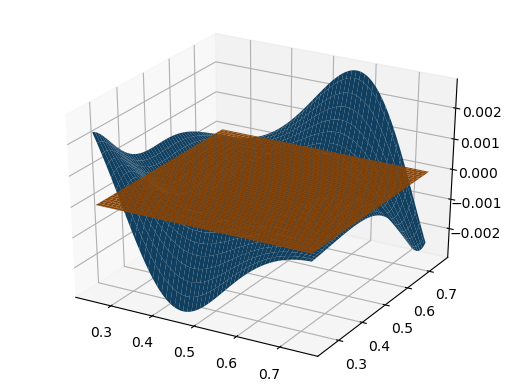

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z.numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
steps =100
x = torch.linspace(0,1,steps=steps)
y = torch.linspace(0,1,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = heat.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
txy = torch.cat((torch.zeros((xy.shape[0],1)),xy),axis=1)
z = heat.Z(txy).detach().reshape(steps,steps,2).squeeze(-1)


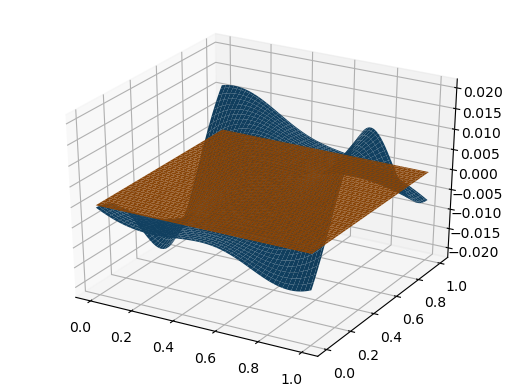

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,0].numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


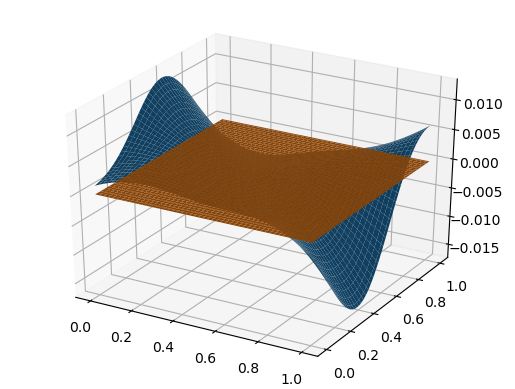

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,1].numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
# Solving semilinear equations

# Solving semilinear equatoins

## Nonlinearity

In [ ]:
class semi_F(object):
    def __init__(self): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        self.kappa=torch.tensor([1]).to(device)
        self.theta=torch.tensor([0.4]).to(device)
        self.lb=torch.tensor([0.15]).to(device)
        self.dim=2
    def eval(self,x,z,a):
        result=torch.zeros([x.shape[0]]).to(device)
        for i in range(self.dim-1):
            result = result - self.kappa[i]*(theta[i]-x[:,i+1,0])*z[:,i+1,0]
        # print(result)
        result1=result-torch.sqrt(torch.sum(torch.square(self.lb)))*torch.abs(z[:,0,0])*torch.abs(a)
        return result1



In [ ]:
F = semi_F()

In [ ]:
class semilinear(object):
    def __init__(self,sigma,mu,F,terminal,T,n,a,b,dim):
        self.num_samples = 2**10
        self.mu = mu
        self.sigma = sigma 
        self.F = F
        self.n = n
        self.x = torch.zeros((self.num_samples,dim+1,n+1))
        self.Y0 = Ynet()
        self.Z = Znet()
        self.terminal = terminal
        self.dt = torch.tensor([T/n]).to(device)
        dw = torch.randn(size=[self.num_samples, dim, n]).to(device)* torch.sqrt(self.dt)
        self.x[:,1:,0]= a+(b-a)*torch.rand(self.num_samples,dim).to(device)
        self.c = torch.zeros((self.num_samples,1,n+1)).to(device)
        self.sigmadw = torch.zeros((self.num_samples,dim,n)).to(device)
        for i in range(self.n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim)),dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt
        self.x = self.x.clone().detach()
        self.sigmadw = self.sigmadw.clone().detach()
        
    def loss(self):
        c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                if i == self.n - 1:
                    c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
                c[:,:,i] = self.F.eval(self.x[:,1:,i].unsqueeze(-1),self.Z(self.x[:,:,i]).unsqueeze(-1),self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0]).unsqueeze(-1)
                Y = Y + torch.tensor([0.0])*self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        return torch.pow(c[:,:,-1]-Y,2).mean()
        
    def train(self):
        t_0 = time.time()
        self.loss_epoch = []
        self.num_epochs = 1000
        self.lr = 1e-2
        parameters = list(heat.Y0.parameters()) + list(heat.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        epoch=0
        while  (torch.abs(L_-loss)>1e-20) & (epoch < self.num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            loss= self.loss()##
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if epoch>0:
                L_ = self.loss_epoch[epoch-1]
            if (epoch % 50==0):
                print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
                self.time_display(t_0,t_1)          
            epoch += 1
                
    def time_display(self,t_0,t_1):
        print("Training this epoch takes {}s.".format(time.time()-t_1))
        print("So far spend {} in training.".format(time.time()-t_0))      
                



In [ ]:
def G_semi(x):
    eta=torch.tensor([0.5]).to(device)
    return (1-torch.exp(-eta*x[:,0])).unsqueeze(-1)


In [ ]:
s = sigma()
m = mu()
k = kappa()
f = source()
g_semi = terminal(G_semi)


In [ ]:
a = torch.tensor([-1.0])
b = torch.tensor([1.0])
semi = semilinear(s,m,F,g_semi,T,num_time_interval,a,b,dim)

In [ ]:
semi.F.eval(semi.x[:,1:,1].unsqueeze(-1),semi.Z(semi.x[:,:,1]).unsqueeze(-1),semi.sigma(semi.x[:,:,1]).reshape((semi.num_samples,dim,dim))[:,0,0])

tensor([-0.1830, -0.0185,  0.6144,  ...,  0.5998,  0.2095, -0.0257],
       grad_fn=<SubBackward0>)

In [ ]:
semi.train()

At epoch 0 the mean error is 0.8017144203186035.
Training this epoch takes 0.03783607482910156s.
So far spend 0.03912973403930664 in training.


## Plot value function

In [ ]:
steps =100
x = torch.linspace(0.25,0.75,steps=steps)
y = torch.linspace(0.25,0.75,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = semi.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
z = semi.Y0(xy).detach().reshape(steps,steps).squeeze(-1)


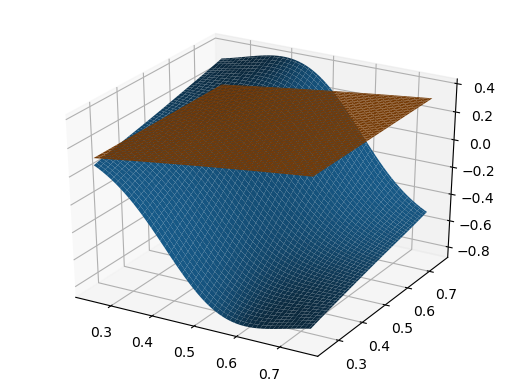

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z.numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
steps =100
x = torch.linspace(0,1,steps=steps)
y = torch.linspace(0,1,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = semi.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
txy = torch.cat((torch.zeros((xy.shape[0],1)),xy),axis=1)
z = semi.Z(txy).detach().reshape(steps,steps,2).squeeze(-1)


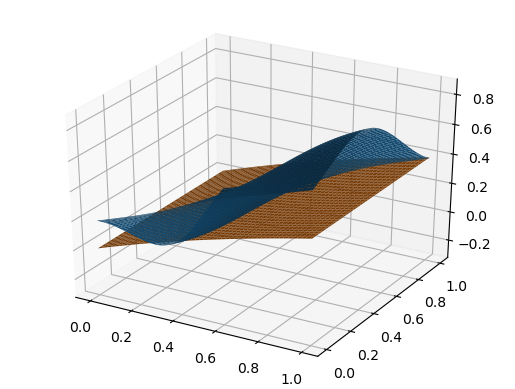

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,0].numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


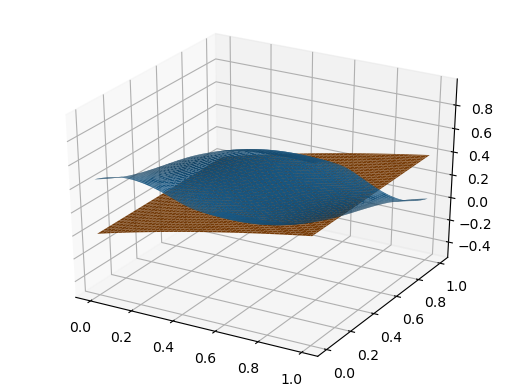

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,1].numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
# Solving semilinear equations